In [1]:
import os, pickle
import numpy as np
import plot_tools as pt
import matplotlib.pylab as plt

In [2]:
# building the dataset
DATASET = {'mice':[],
           'days':[],
           'folders':[]}

data_folder = os.path.join(os.path.expanduser('~'), 'DATA', 'Marcel_Data')
days = [d for d in os.listdir(data_folder) if (('._' not in d) and ('.DS' not in d))]
for day in days:
    mice = [f for f in os.listdir(os.path.join(data_folder, day)) if '.DS' not in f]
    for m in mice:
        folders = [f for f in os.listdir(os.path.join(data_folder, day, m)) if '.DS' not in f]
        for f in folders:
            DATASET['mice'].append(m)
            DATASET['days'].append(day)
            DATASET['folders'].append(os.path.join(data_folder, day, m, f))

In [6]:
DATASET['with_whisking'] = np.zeros(len(DATASET['days']), dtype=bool)
for i, f in enumerate(DATASET['folders']):
    with open(os.path.join(f, 'Analysis_Data.pickle'), 'rb') as f:
        try:
            data = pickle.load(f)
            if 'Whisking_data' in data:
                DATASET['with_whisking'][i] = True
        except BaseException:
            print('pb with', i, f)
    #print('%i /' % (i+1), len(DATASET['days']))
print('N=%i sessions with whisking data' % np.sum(DATASET['with_whisking']))

N=87 sessions with whisking data


In [7]:
def load_data(f):
    with open(os.path.join(f, 'Analysis_Data.pickle'), 'rb') as F:
        data = pickle.load(F)
    return data.copy()

In [15]:
RESULTS = {'running':[], 'whisking':[],
           'run_whisk':[], 
           'run_only':[], 'whisk_only':[]} 
for i, f in enumerate(np.array(DATASET['folders'])[DATASET['with_whisking']]):
    data = load_data(f)
    running = data['Locomotion_data']['bool_binary_movement']
    RESULTS['running'].append(np.sum(running)/len(running))
    whisking = data['Whisking_data']['binary_whisking']
    RESULTS['whisking'].append(np.sum(whisking)/len(running))
    RESULTS['run_whisk'].append(np.sum(running & whisking)/len(running))
    RESULTS['run_only'].append(np.sum(running & (~whisking))/len(running))
    RESULTS['whisk_only'].append(np.sum(whisking & (~running))/len(running))

running : 0.324 +/- 0.015 
whisking : 0.476 +/- 0.024 
run_whisk : 0.293 +/- 0.015 
run_only : 0.031 +/- 0.004 
whisk_only : 0.183 +/- 0.018 


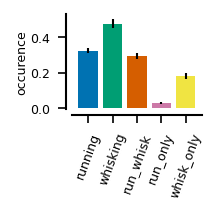

In [27]:
from scipy import stats
fig, ax = pt.figure()
for i, key in enumerate(RESULTS):
    print('%s : %.3f +/- %.3f ' % (key, np.mean(RESULTS[key]), stats.sem(RESULTS[key])))
    ax.bar([i], [np.mean(RESULTS[key])], yerr=[stats.sem(RESULTS[key])])
pt.set_plot(ax,
            xticks = range(i+1), xticks_labels=list(RESULTS.keys()),
            fontsize=6, xticks_rotation=70, ylabel='occurence')

In [28]:
LMIs, n = [], 0
for i, f in enumerate(np.array(DATASET['folders'])[DATASET['with_whisking']]):
    with open(os.path.join(f, 'Analysis_Data.pickle'), 'rb') as F:
        data = pickle.load(F)
        if 'lmi' in data:
            LMIs += data['lmi']
            n+=1
        else:
            print('Pb with:', f)
print('N=%i sessions' % n )

Pb with: /Users/yann/DATA/Marcel_Data/2022.04.13/M_142/TSeries-04132022-1613-003
Pb with: /Users/yann/DATA/Marcel_Data/2022.04.12/M_142/TSeries-02262021-1332-001
N=85 sessions


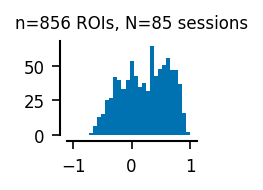

In [29]:
fig, ax = pt.figure()
ax.hist(LMIs, bins=np.linspace(-1,1,30))
pt.set_plot(ax, xticks=[-1,0,1],
            title='n=%i ROIs, N=%i sessions' % (len(LMIs), n))